In [1]:
import torch
import torch.nn.functional as F

from mscgpt.data_handler import DataHandler
from mscgpt.tokenizer import Tokenizer
from mscgpt.gpt import MicroSCGPT, GeneExpressionRegressor

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
CONTEXT_SIZE = 128
LEARNING_RATE = 1e-4
N_HEADS = 4
N_LAYERS = 6
N_EMBED = 256
N_TRAIN_STEPS = 5000
INTERVAL_EVAL = 100
N_EVAL = 200

In [27]:
tk = Tokenizer()
dh = DataHandler(BATCH_SIZE, CONTEXT_SIZE, tk.pad_token, device=DEVICE)

tokenized_data = tk.load_pretraining_dataset("tabmuris_A")
tokenized_data = tk.load_pretraining_dataset("humaneye")
dh.load_dataset(tokenized_data)

> Tokenizer: 6395 genes successfully loaded.
> Data Handler: Dataset successfully loaded.


In [31]:
def gene_expression_loss(x_gid, x_bin, estimate, pad_token):
    # x_gid: [B, T]
    # x_bin: [B, T]
    # estimate: [B, V]
    target = torch.zeros(estimate.shape).type(torch.long).to(DEVICE)
    nnz = (x_gid != pad_token).nonzero().to(DEVICE)
    target[nnz[:, 0], x_gid[nnz[:, 0], nnz[:, 1]]] = x_bin[nnz[:, 0], nnz[:, 1]]
    return F.mse_loss(estimate.type(torch.float), target.type(torch.float))

@torch.no_grad()
def estimate_loss(model_gpt, model_gexpr, eval_iters):
  out = {}
  model_gpt.eval()
  model_gexpr.eval()
  for split in ('train', 'val'):
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      x_gid, x_bin = dh.get_batch(split)
      x_emb = model_gpt(x_gid, x_bin)
      estimate = model_gexpr(x_emb)
      losses[k] = gene_expression_loss(x_gid, x_bin, estimate, tk.pad_token).item()
    out[split] = losses.mean()
  model_gpt.train()
  model_gexpr.train()
  return out

In [29]:
gpt = MicroSCGPT(CONTEXT_SIZE, tk.bins_size, tk.vocab_size, N_HEADS, N_LAYERS, N_EMBED, N_EMBED)
gexpr = GeneExpressionRegressor(CONTEXT_SIZE, N_EMBED, tk.n_genes)
gpt = gpt.to(DEVICE)
gexpr = gexpr.to(DEVICE)
optimizer = torch.optim.AdamW(
  list(gpt.parameters()) + list(gexpr.parameters()), 
  lr=LEARNING_RATE
)

> MicroSCGPT: Model initialized with 4410112 parameters.


In [32]:
print(f'> Starting training on {DEVICE}: {torch.cuda.get_device_name(0)}.')

rec_loss = []
for step in range(N_TRAIN_STEPS):
  if not (step % INTERVAL_EVAL) or step == N_TRAIN_STEPS - 1:
    loss = estimate_loss(gpt, gexpr, N_EVAL)
    print(f'Step {step}, loss={loss["train"]:.4f} (train), {loss["val"]:.4f} (val)')
  x_gid, x_bin = dh.get_batch("train")
  x_emb = gpt(x_gid, x_bin)
  estimate = gexpr(x_emb)
  loss = gene_expression_loss(x_gid, x_bin, estimate, tk.pad_token)
  rec_loss.append(float(loss.detach()))
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

> Starting training on cuda: Radeon RX 7900 XT.
Step 0, loss=0.2181 (train), 0.2215 (val)
Step 100, loss=0.0797 (train), 0.0828 (val)
Step 200, loss=0.0624 (train), 0.0668 (val)
Step 300, loss=0.0618 (train), 0.0644 (val)
Step 400, loss=0.0611 (train), 0.0626 (val)
Step 500, loss=0.0605 (train), 0.0648 (val)
Step 600, loss=0.0610 (train), 0.0631 (val)
Step 700, loss=0.0601 (train), 0.0641 (val)
Step 800, loss=0.0604 (train), 0.0638 (val)
Step 900, loss=0.0605 (train), 0.0649 (val)
Step 1000, loss=0.0611 (train), 0.0637 (val)
Step 1100, loss=0.0602 (train), 0.0636 (val)
Step 1200, loss=0.0611 (train), 0.0632 (val)
Step 1300, loss=0.0603 (train), 0.0635 (val)
Step 1400, loss=0.0598 (train), 0.0646 (val)
Step 1500, loss=0.0600 (train), 0.0638 (val)
Step 1600, loss=0.0609 (train), 0.0646 (val)
Step 1700, loss=0.0597 (train), 0.0636 (val)
Step 1800, loss=0.0610 (train), 0.0639 (val)
Step 1900, loss=0.0607 (train), 0.0633 (val)
Step 2000, loss=0.0611 (train), 0.0645 (val)
Step 2100, loss=0.0

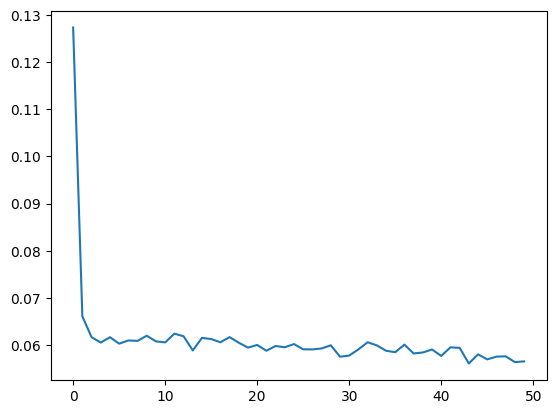

In [33]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(rec_loss).view(-1, 100).mean(axis=-1))

In [ ]:
# Our model can overfit the data :) Next, we'll add some training masks.